# Business Case

**Function for making data readable**

In [4]:
process_hr_data_readable <- function(data, definitions_tbl) {

    definitions_list <- definitions_tbl %>%
        fill(...1, .direction = "down") %>%
        filter(!is.na(...2)) %>%
        separate(...2, into = c("key", "value"), sep = " '", remove = TRUE) %>%
        rename(column_name = ...1) %>%
        mutate(key = as.numeric(key)) %>%
        mutate(value = value %>% str_replace(pattern = "'", replacement = "")) %>%
        split(.$column_name) %>%
        map(~ select(., -column_name)) %>%
        map(~ mutate(., value = as_factor(value))) 
    
    for (i in seq_along(definitions_list)) {
        list_name <- names(definitions_list)[i]
        colnames(definitions_list[[i]]) <- c(list_name, paste0(list_name, "_value"))
    }
    
    data_merged_tbl <- list(HR_Data = data) %>%
        append(definitions_list, after = 1) %>%
        reduce(left_join) %>%
        select(-one_of(names(definitions_list))) %>%
        set_names(str_replace_all(names(.), pattern = "_value", 
                                            replacement = "")) %>%
        select(sort(names(.))) %>%
        mutate_if(is.character, as.factor) %>%
        mutate(
            BusinessTravel = BusinessTravel %>% fct_relevel("Non-Travel", 
                                                            "Travel_Rarely", 
                                                            "Travel_Frequently"),
            MaritalStatus  = MaritalStatus %>% fct_relevel("Single", 
                                                           "Married", 
                                                           "Divorced")
        )
    
    return(data_merged_tbl)
    
}
process_hr_data_readable(employee_attrition_tbl, definitions_raw_tbl) %>% 
  glimpse()

Joining with `by = join_by(Education)`
Joining with `by = join_by(EnvironmentSatisfaction)`
Joining with `by = join_by(JobInvolvement)`
Joining with `by = join_by(JobSatisfaction)`
Joining with `by = join_by(PerformanceRating)`
Joining with `by = join_by(RelationshipSatisfaction)`
Joining with `by = join_by(WorkLifeBalance)`


Rows: 1,470
Columns: 35
$ Age                      <dbl> 41, 49, 37, 33, 27, 32, 59, 30, 38, 36, 35, 2…
$ Attrition                <fct> Yes, No, Yes, No, No, No, No, No, No, No, No,…
$ BusinessTravel           <fct> Travel_Rarely, Travel_Frequently, Travel_Rare…
$ DailyRate                <dbl> 1102, 279, 1373, 1392, 591, 1005, 1324, 1358,…
$ Department               <fct> Sales, Research & Development, Research & Dev…
$ DistanceFromHome         <dbl> 1, 8, 2, 3, 2, 2, 3, 24, 23, 27, 16, 15, 26, …
$ Education                <fct> College, Below College, College, Master, Belo…
$ EducationField           <fct> Life Sciences, Life Sciences, Other, Life Sci…
$ EmployeeCount            <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, …
$ EmployeeNumber           <dbl> 1, 2, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16,…
$ EnvironmentSatisfaction  <fct> Medium, High, Very High, Very High, Low, Very…
$ Gender                   <fct> Female, Male, Male, Female, Male, Male, Femal…
$ HourlyRate    

In [8]:
# LIME FEATURE EXPLANATION ----

# 1. Setup ----

# Load Libraries 

library(h2o)
library(recipes)
library(readxl)
library(tidyverse)
library(tidyquant)
library(lime)
library(rsample)

# Load Data
employee_attrition_tbl <- read_csv("/kaggle/input/bdml-dataset/datasets-1067-1925-WA_Fn-UseC_-HR-Employee-Attrition.csv")
definitions_raw_tbl    <- read_excel("/kaggle/input/bdml-dataset/Business Decisions with Machine Learning/Business Decisions with Machine Learning/data_definitions.xlsx", sheet = 1, col_names = FALSE)

# Processing Pipeline
#source("00_Scripts/data_processing_pipeline.R")

employee_attrition_readable_tbl <- process_hr_data_readable(employee_attrition_tbl, definitions_raw_tbl)

# Split into test and train
set.seed(seed = 1113)
split_obj <- rsample::initial_split(employee_attrition_readable_tbl, prop = 0.85)

# Assign training and test data
train_readable_tbl <- training(split_obj)
test_readable_tbl  <- testing(split_obj)

# ML Preprocessing Recipe 
recipe_obj <- recipe(Attrition ~ ., data = train_readable_tbl) %>%
                step_zv(all_predictors()) %>%
                step_mutate_at(c("JobLevel", "StockOptionLevel"), fn = as.factor) %>% 
                prep()

recipe_obj

train_tbl <- bake(recipe_obj, new_data = train_readable_tbl)
test_tbl  <- bake(recipe_obj, new_data = test_readable_tbl)

# 2. Models ----

h2o.init()

#automl_leader <- h2o.loadModel("04_Modeling/h20_models/StackedEnsemble_BestOfFamily_AutoML_20200903_144246")
automl_leader <- h2o.loadModel("/kaggle/input/bdml-dataset/StackedEnsemble_AllModels_1_AutoML_1_20230615_121647")
automl_leader

Rows: 1470 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): Attrition, BusinessTravel, Department, EducationField, Gender, Job...
dbl (26): Age, DailyRate, DistanceFromHome, Education, EmployeeCount, Employ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
• `` -> `...2`
Joining with `by = join_by(Education)`
Joining with `by = join_by(EnvironmentSatisfaction)`
Joining with `by = join_by(JobInvolvement)`
Joining with `by = join_by(JobSatisfaction)`
Joining with `by = join_by(PerformanceRating)`
Joining with `by = join_by(RelationshipSatisfaction)`
Joining with `by = join_by(WorkLifeBalance)`


── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:    1
predictor: 34



── Training information 

Training data 


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpRlMpoS/file234a6dc9a6/h2o_UnknownUser_started_from_r.out
    /tmp/RtmpRlMpoS/file2369952a81/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: .... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         3 seconds 209 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.40.0.1 
    H2O cluster version age:    4 months and 6 days 
    H2O cluster name:           H2O_started_from_R_root_drs368 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   7.50 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:     

Warning message in h2o.clusterInfo():
“
Your H2O cluster version is (4 months and 6 days) old. There may be a newer version available.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html”


Model Details:

H2OBinomialModel: stackedensemble
Model ID:  StackedEnsemble_AllModels_1_AutoML_1_20230615_121647 
Model Summary for Stacked Ensemble: 
                                    key            value
1                     Stacking strategy cross_validation
2  Number of base models (used / total)              3/8
3      # GBM base models (used / total)              2/4
4  # XGBoost base models (used / total)              0/2
5      # GLM base models (used / total)              1/1
6      # DRF base models (used / total)              0/1
7                 Metalearner algorithm              GLM
8    Metalearner fold assignment scheme           Random
9                    Metalearner nfolds                5
10              Metalearner fold_column               NA
11   Custom metalearner hyperparameters             None


H2OBinomialMetrics: stackedensemble
** Reported on training data. **

MSE:  0.05734845
RMSE:  0.2394754
LogLoss:  0.2124292
Mean Per-Class Error:  0.147035
AUC:  

**Prediction**

In [9]:
# 3. LIME ----

# 3.1 Making Predictions ----

predictions_tbl <- automl_leader %>% 
    h2o.predict(newdata = as.h2o(test_tbl)) %>%
    as.tibble() %>%
    bind_cols(
        test_tbl %>%
            select(Attrition, EmployeeNumber)
    )

predictions_tbl

Warning message:
“`as.tibble()` was deprecated in tibble 2.0.0.
ℹ Please use `as_tibble()` instead.
ℹ The signature and semantics have changed, see `?as_tibble`.”


  |======================================================================| 100%
  |======================================================================| 100%


predict,No,Yes,Attrition,EmployeeNumber
<fct>,<dbl>,<dbl>,<fct>,<dbl>
No,0.6316129,0.368387150,No,10
No,0.7760366,0.223963361,No,16
No,0.9073922,0.092607794,No,30
No,0.9168272,0.083172833,Yes,31
No,0.9615491,0.038450930,No,40
No,0.9913401,0.008659876,Yes,42
No,0.9930712,0.006928818,No,46
Yes,0.2328364,0.767163570,Yes,55
Yes,0.3085970,0.691403036,Yes,64


**Investigate 1st employee**

In [10]:
test_tbl %>%
    slice(1) %>%
    glimpse()

Rows: 1
Columns: 32
$ Age                      <dbl> 59
$ BusinessTravel           <fct> Travel_Rarely
$ DailyRate                <dbl> 1324
$ Department               <fct> Research & Development
$ DistanceFromHome         <dbl> 3
$ Education                <fct> Bachelor
$ EducationField           <fct> Medical
$ EmployeeNumber           <dbl> 10
$ EnvironmentSatisfaction  <fct> High
$ Gender                   <fct> Female
$ HourlyRate               <dbl> 81
$ JobInvolvement           <fct> Very High
$ JobLevel                 <fct> 1
$ JobRole                  <fct> Laboratory Technician
$ JobSatisfaction          <fct> Low
$ MaritalStatus            <fct> Married
$ MonthlyIncome            <dbl> 2670
$ MonthlyRate              <dbl> 9964
$ NumCompaniesWorked       <dbl> 4
$ OverTime                 <fct> Yes
$ PercentSalaryHike        <dbl> 20
$ PerformanceRating        <fct> Outstanding
$ RelationshipSatisfaction <fct> Low
$ StockOptionLevel         <fct> 3
$ TotalWorkingYears    

In [11]:
# 3.2 Single Explanation ----

explainer <- train_tbl %>%
    select(-Attrition) %>%
    lime(
        model           = automl_leader,
        bin_continuous  = TRUE,
        n_bins          = 4,
        quantile_bins   = TRUE
    )

explainer

$model
Model Details:

H2OBinomialModel: stackedensemble
Model ID:  StackedEnsemble_AllModels_1_AutoML_1_20230615_121647 
Model Summary for Stacked Ensemble: 
                                    key            value
1                     Stacking strategy cross_validation
2  Number of base models (used / total)              3/8
3      # GBM base models (used / total)              2/4
4  # XGBoost base models (used / total)              0/2
5      # GLM base models (used / total)              1/1
6      # DRF base models (used / total)              0/1
7                 Metalearner algorithm              GLM
8    Metalearner fold assignment scheme           Random
9                    Metalearner nfolds                5
10              Metalearner fold_column               NA
11   Custom metalearner hyperparameters             None


H2OBinomialMetrics: stackedensemble
** Reported on training data. **

MSE:  0.05734845
RMSE:  0.2394754
LogLoss:  0.2124292
Mean Per-Class Error:  0.147035

In [12]:
explanation <- test_tbl %>%
    slice(1) %>%
    select(-Attrition) %>%
    lime::explain(
    
        # Pass our explainer object
        explainer = explainer,
        # Because it is a binary classification model: 1
        n_labels   = 1,
        # number of features to be returned
        n_features = 8,
        # number of localized linear models
        n_permutations = 5000,
        # Let's start with 1
        kernel_width   = 1
    )

explanation

  |======================================================================| 100%
  |======================================================================| 100%


model_type,case,label,label_prob,model_r2,model_intercept,model_prediction,feature,feature_value,feature_weight,feature_desc,data,prediction
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<list>,<list>
classification,1,No,0.6316129,0.3137134,0.8753886,0.5929623,OverTime,2,-0.19935223,OverTime = Yes,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.3137134,0.8753886,0.5929623,JobLevel,1,-0.08701331,JobLevel = 1,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.3137134,0.8753886,0.5929623,YearsSinceLastPromotion,0,0.07592291,YearsSinceLastPromotion <= 1,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.3137134,0.8753886,0.5929623,JobSatisfaction,1,-0.06068700,JobSatisfaction = Low,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.3137134,0.8753886,0.5929623,RelationshipSatisfaction,1,-0.06106715,RelationshipSatisfaction = Low,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.3137134,0.8753886,0.5929623,Department,2,0.04896450,Department = Research & Development,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.3137134,0.8753886,0.5929623,JobInvolvement,4,0.04673849,JobInvolvement = Very High,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.3137134,0.8753886,0.5929623,YearsWithCurrManager,0,-0.04593252,YearsWithCurrManager <= 2,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"


**Select column**

In [13]:
explanation %>%
    as.tibble() %>%
    select(feature:prediction) 

feature,feature_value,feature_weight,feature_desc,data,prediction
<chr>,<dbl>,<dbl>,<chr>,<list>,<list>
OverTime,2,-0.19935223,OverTime = Yes,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
JobLevel,1,-0.08701331,JobLevel = 1,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
YearsSinceLastPromotion,0,0.07592291,YearsSinceLastPromotion <= 1,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
JobSatisfaction,1,-0.06068700,JobSatisfaction = Low,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
RelationshipSatisfaction,1,-0.06106715,RelationshipSatisfaction = Low,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
Department,2,0.04896450,Department = Research & Development,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
JobInvolvement,4,0.04673849,JobInvolvement = Very High,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
YearsWithCurrManager,0,-0.04593252,YearsWithCurrManager <= 2,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"


**Plot**

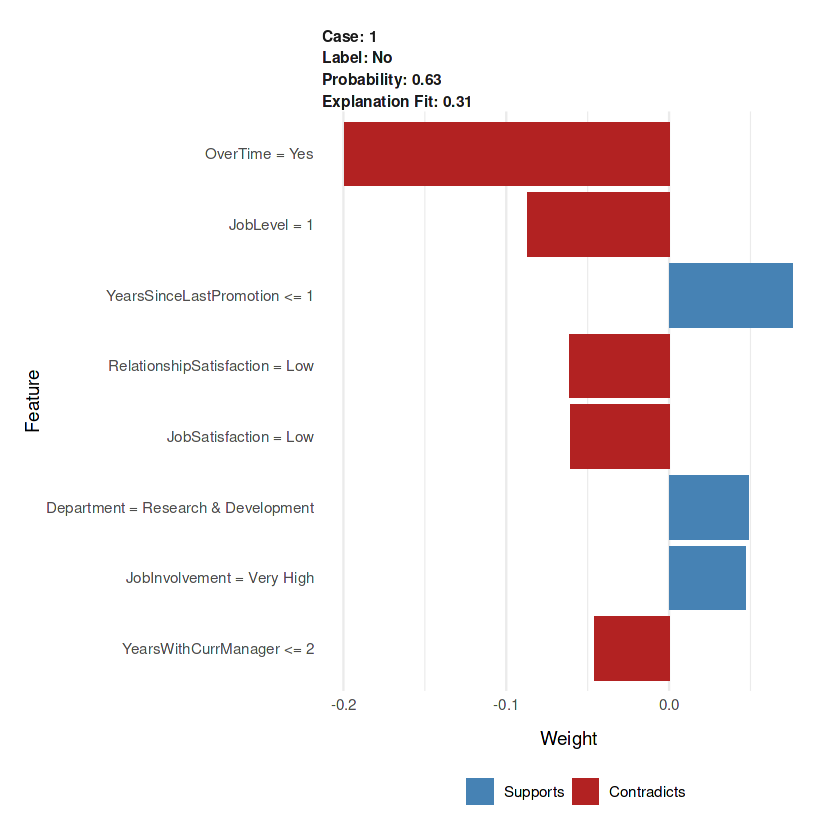

In [16]:
g <- plot_features(explanation = explanation, ncol = 1)
g

**Plot multiple explanations**

  |======================================================================| 100%
  |======================================================================| 100%


model_type,case,label,label_prob,model_r2,model_intercept,model_prediction,feature,feature_value,feature_weight,feature_desc,data,prediction
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<list>,<list>
classification,1,No,0.6316129,0.2981668,0.8656775,0.5825722,OverTime,2,-0.20057423,OverTime = Yes,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.2981668,0.8656775,0.5825722,JobLevel,1,-0.07634809,JobLevel = 1,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.2981668,0.8656775,0.5825722,YearsSinceLastPromotion,0,0.06980719,YearsSinceLastPromotion <= 1,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.2981668,0.8656775,0.5825722,JobSatisfaction,1,-0.06265670,JobSatisfaction = Low,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.2981668,0.8656775,0.5825722,RelationshipSatisfaction,1,-0.06147540,RelationshipSatisfaction = Low,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.2981668,0.8656775,0.5825722,YearsWithCurrManager,0,-0.04940850,YearsWithCurrManager <= 2,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.2981668,0.8656775,0.5825722,Department,2,0.05149226,Department = Research & Development,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.2981668,0.8656775,0.5825722,YearsAtCompany,1,0.04605825,YearsAtCompany <= 3,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,2,No,0.7760366,0.3948528,0.7481032,0.6766202,OverTime,1,0.20611170,OverTime = No,"31, 2, 670, 2, 26, 1, 2, 16, 1, 2, 31, 3, 1, 7, 3, 3, 2911, 15170, 1, 1, 17, 3, 4, 2, 5, 1, 2, 5, 2, 4, 3","0.7760366, 0.2239634"


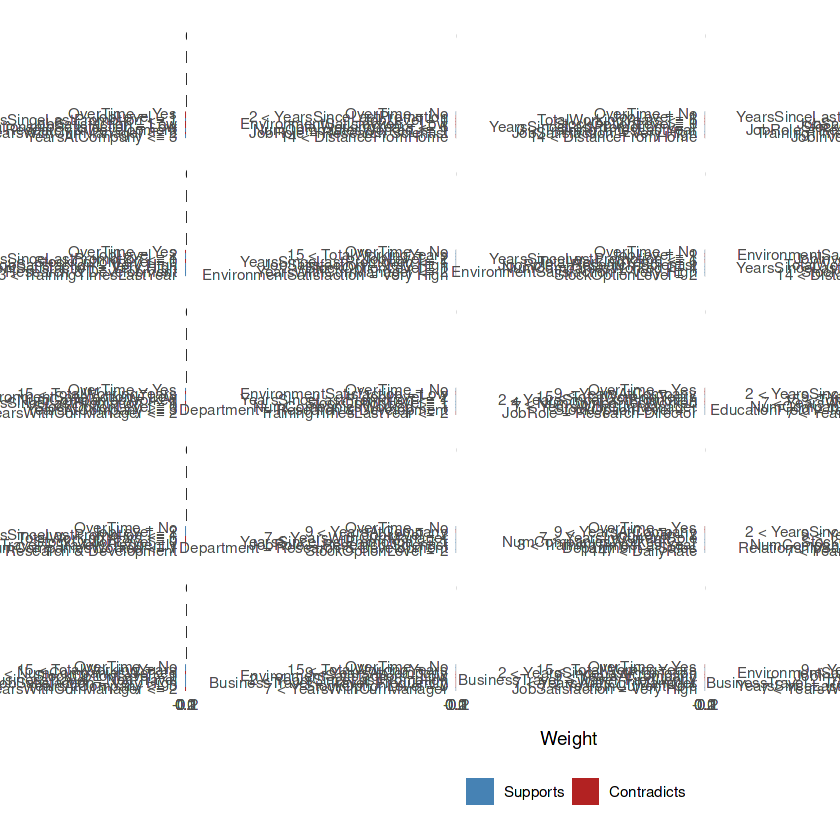

In [17]:
# 3.3 Multiple Explanations ----

explanation <- test_tbl %>%
    slice(1:20) %>%
    select(-Attrition) %>%
    lime::explain(
        explainer = explainer,
        n_labels   = 1,
        n_features = 8,
        n_permutations = 5000,
        kernel_width   = 0.5
    )

explanation %>%
    as.tibble()

plot_features(explanation, ncol = 4)

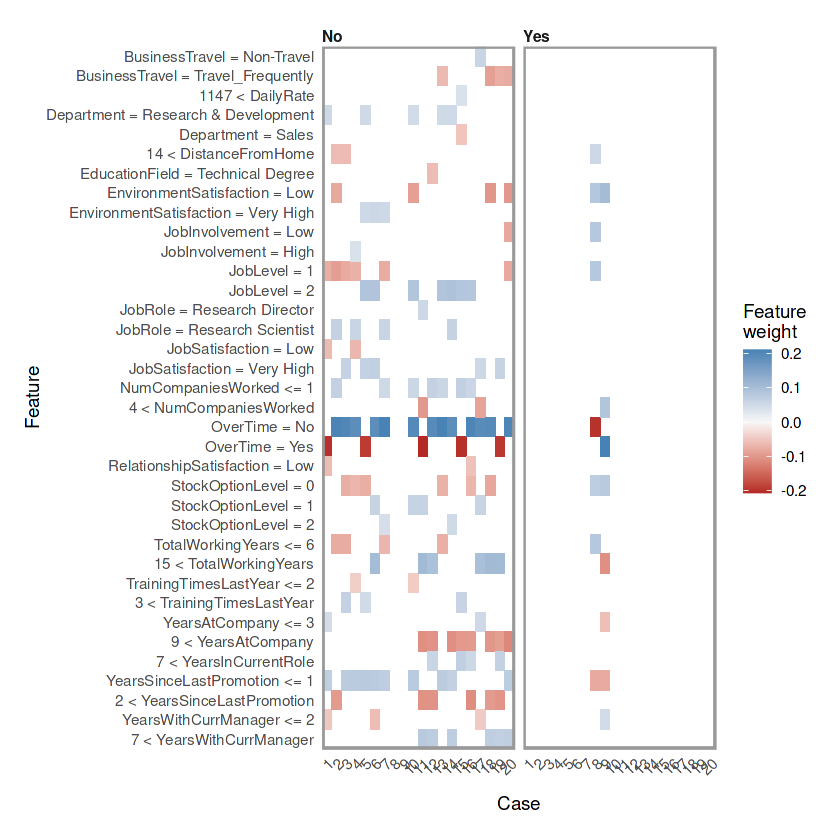

In [18]:
plot_explanations(explanation)

# Challenge


model_type,case,label,label_prob,model_r2,model_intercept,model_prediction,feature,feature_value,feature_weight,feature_desc,data,prediction
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<list>,<list>
classification,1,No,0.6316129,0.2981668,0.8656775,0.5825722,OverTime,2,-0.20057423,OverTime = Yes,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.2981668,0.8656775,0.5825722,JobLevel,1,-0.07634809,JobLevel = 1,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.2981668,0.8656775,0.5825722,YearsSinceLastPromotion,0,0.06980719,YearsSinceLastPromotion <= 1,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.2981668,0.8656775,0.5825722,JobSatisfaction,1,-0.06265670,JobSatisfaction = Low,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.2981668,0.8656775,0.5825722,RelationshipSatisfaction,1,-0.06147540,RelationshipSatisfaction = Low,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.2981668,0.8656775,0.5825722,YearsWithCurrManager,0,-0.04940850,YearsWithCurrManager <= 2,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.2981668,0.8656775,0.5825722,Department,2,0.05149226,Department = Research & Development,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,1,No,0.6316129,0.2981668,0.8656775,0.5825722,YearsAtCompany,1,0.04605825,YearsAtCompany <= 3,"59, 2, 1324, 2, 3, 3, 4, 10, 3, 1, 81, 4, 1, 3, 1, 2, 2670, 9964, 4, 2, 20, 4, 1, 4, 12, 3, 2, 1, 0, 0, 0","0.6316129, 0.3683871"
classification,2,No,0.7760366,0.3948528,0.7481032,0.6766202,OverTime,1,0.20611170,OverTime = No,"31, 2, 670, 2, 26, 1, 2, 16, 1, 2, 31, 3, 1, 7, 3, 3, 2911, 15170, 1, 1, 17, 3, 4, 2, 5, 1, 2, 5, 2, 4, 3","0.7760366, 0.2239634"


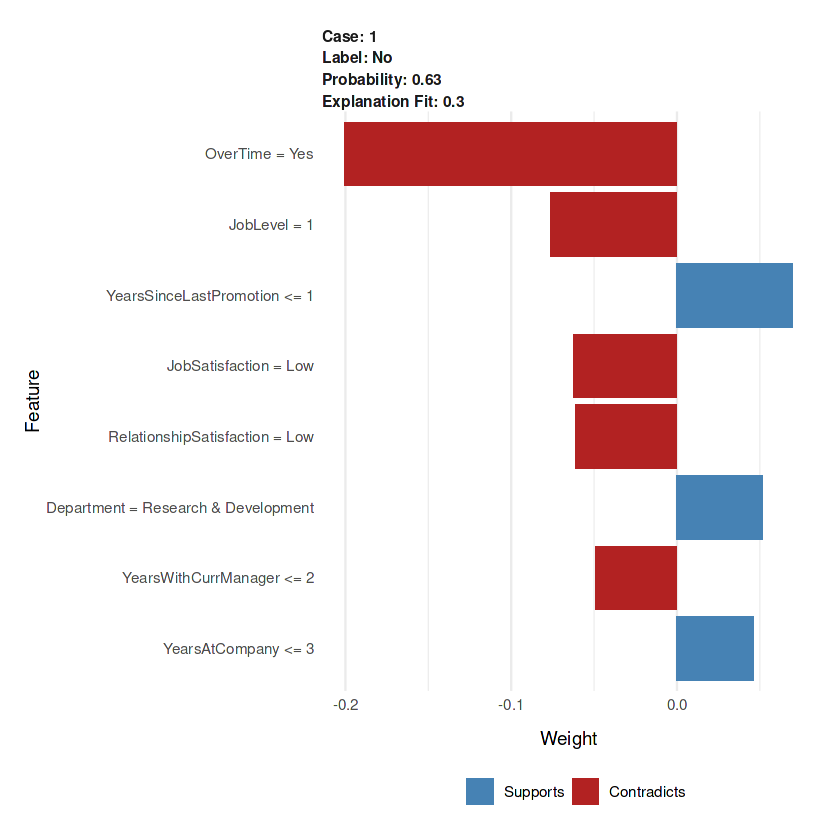

In [19]:
explanation %>% 
  as.tibble()
  
case_1 <- explanation %>%
    filter(case == 1)

case_1 %>%
    plot_features()

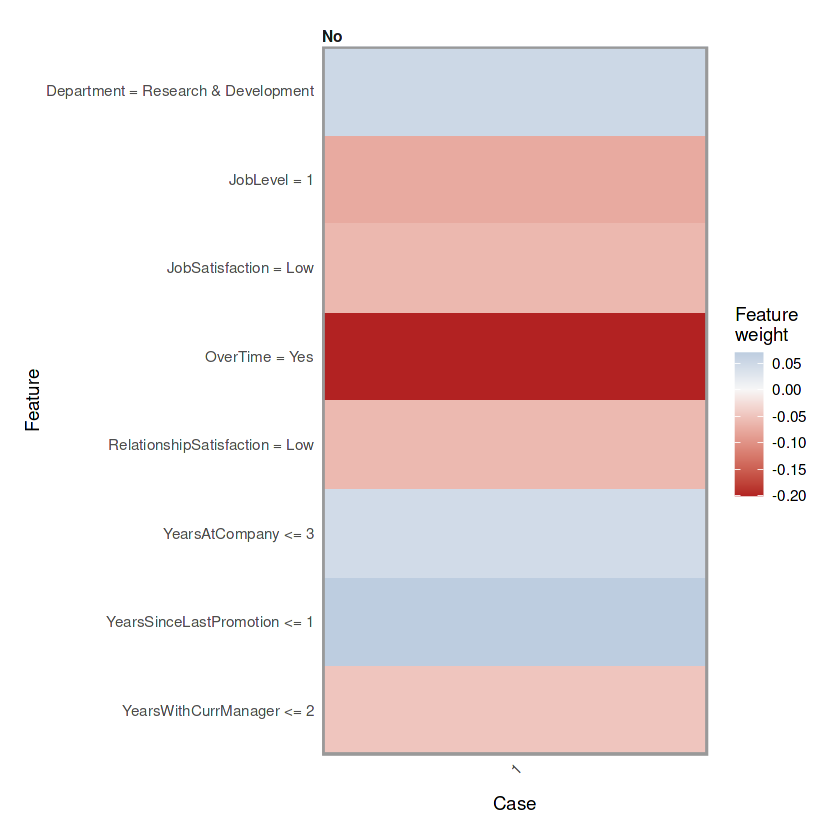

In [21]:
plot_explanations(case_1)

# Recreate plot_explanations()

In [22]:
library(ggplot2)

explanation_tibble <- explanation %>%
  as.tibble()

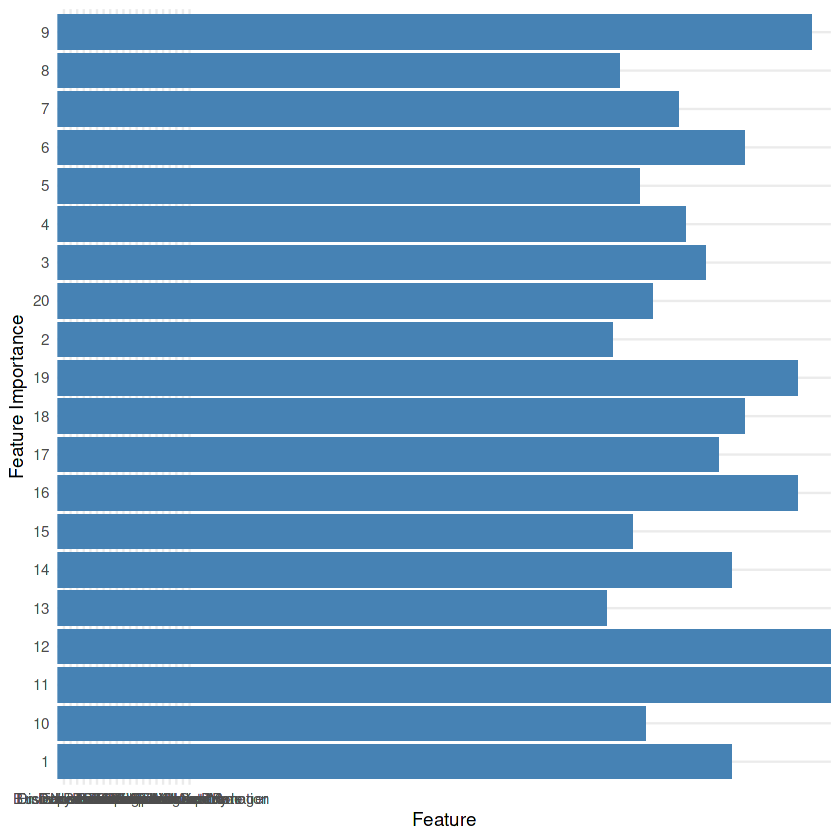

In [29]:

# Plot using geom_col() and coord_flip()
plot <- ggplot(explanation_tibble, aes(x = case, y = feature)) +
  geom_col(fill = "steelblue") +
  coord_flip() +
  labs(x = "Feature Importance", y = "Feature") +
  theme_minimal()

# Display the plot
plot